In [185]:
import pandas as pd
import numpy as np
pd.set_option("display.max.columns",None)
pd.set_option("display.max.rows",None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew
import fbprophet
Prophet = fbprophet.Prophet
import utility
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import performance_metrics

In [186]:
features = pd.read_csv('features.csv')
submission = pd.read_csv('sampleSubmission.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train = train.drop(columns=['IsHoliday'],axis = 1)

In [187]:

store_features = stores.merge(features,on = 'Store',how = 'inner')

In [188]:
store_data = train.merge(store_features,on = ['Store','Date'],how = 'right')

In [189]:
store_data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday'],
      dtype='object')

In [190]:
dataset = store_data.drop(columns = ['Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5','Unemployment'],axis = 1)

In [191]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,CPI,IsHoliday
0,1,1.0,2010-02-05,24924.50,A,151315,211.096358,False
1,1,2.0,2010-02-05,50605.27,A,151315,211.096358,False
2,1,3.0,2010-02-05,13740.12,A,151315,211.096358,False
3,1,4.0,2010-02-05,39954.04,A,151315,211.096358,False
4,1,5.0,2010-02-05,32229.38,A,151315,211.096358,False


In [192]:
dataset_for_prediction=dataset.dropna()

In [193]:
# dataset_for_prediction['Date'] =pd.to_datetime(dataset_for_prediction['Date'])
# dataset_for_prediction.index= dataset_for_prediction['Date']

In [194]:
dataset_grouped = dataset_for_prediction.groupby(['Date','Store','Dept','CPI'])['Weekly_Sales'].sum().reset_index()

In [195]:
Store1 = dataset_grouped[dataset_grouped.Store.isin([1])]

In [196]:
Store1.head()

,Date,Store,Dept,CPI,Weekly_Sales
0,2010-02-05,1,1.0,211.096358,24924.50
1,2010-02-05,1,2.0,211.096358,50605.27
2,2010-02-05,1,3.0,211.096358,13740.12
3,2010-02-05,1,4.0,211.096358,39954.04
4,2010-02-05,1,5.0,211.096358,32229.38


In [15]:
steps=0
dataset_for_prediction1= Store1.copy()
# dataset_for_prediction1['Actual_sales']=dataset_for_prediction1['Weekly_Sales'].shift(steps)
dataset_for_prediction1.head(3)

,Date,Store,Dept,CPI,Weekly_Sales
0,2010-02-05,1,1.0,211.096358,24924.50
1,2010-02-05,1,2.0,211.096358,50605.27
2,2010-02-05,1,3.0,211.096358,13740.12


In [16]:
dataset_grouped = dataset_for_prediction1.groupby(['Date','Store','CPI'])['Weekly_Sales'].sum().reset_index()

In [17]:
dataset_for_prediction2=dataset_grouped.dropna()
dataset_for_prediction2['Date'] =pd.to_datetime(dataset_for_prediction2['Date'])
dataset_for_prediction2.index= dataset_for_prediction2['Date']

In [18]:
# Store1 = dataset_grouped[dataset_grouped.Store.isin([1,2])]
# Store1.head()
dataset_for_prediction2.Store.value_counts()
Store1 = dataset_for_prediction2.copy()

1    143
Name: Store, dtype: int64

In [19]:
Store1 = Store1.rename(columns = {'Date':'ds','Weekly_Sales':'y'})
datetime_series = pd.to_datetime(Store1['ds'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

Store1_data=Store1.set_index(datetime_index)

In [20]:
Store1_data.head(2)

,ds,Store,CPI,y
2010-02-05,2010-02-05,1,211.096358,1643690.90
2010-02-12,2010-02-12,1,211.242170,1641957.44


In [21]:
SC =  Store1_data[['y']]

In [22]:
SC_with_regressors = utility.add_regressor(SC, Store1_data, varname='Store')
SC_with_regressors = utility.add_regressor(SC_with_regressors, Store1_data, varname='CPI')
# SC_with_regressors = utility.add_regressor(SC_with_regressors, Store1_data, varname='Dept')

In [23]:
data_train, data_test = utility.prepare_data(SC_with_regressors, 2012)

In [24]:
data_test.head()

,index,y,Store,CPI
0,2012-01-06,1550369.92,1,219.714258
1,2012-01-13,1459601.17,1,219.892526
2,2012-01-20,1394393.84,1,219.985689
3,2012-01-27,1319325.59,1,220.078852
4,2012-02-03,1636339.65,1,220.172015


In [25]:
m = Prophet(changepoint_prior_scale=0.05, interval_width=0.95,growth = 'linear',seasonality_mode = 'multiplicative', \
               yearly_seasonality=20, \
            weekly_seasonality=True, \
#             daily_seasonality=False,\
            changepoint_range=0.9)
m.add_seasonality('weekly', period=7, fourier_order=15)

In [26]:
m.add_regressor('Store')
# m.add_regressor('Dept')
m.add_regressor('CPI')

In [27]:
data_train.head()
data_train = data_train.rename(columns = {'index':'ds'})
data_test = data_test.rename(columns = {'index':'ds'})
data_train.ds = pd.to_datetime(data_train.ds)
data_test.ds = pd.to_datetime(data_test.ds)
data_test.head()


,index,y,Store,CPI
0,2010-02-05,1643690.90,1,211.096358
1,2010-02-12,1641957.44,1,211.242170
2,2010-02-19,1611968.17,1,211.289143
3,2010-02-26,1409727.59,1,211.319643
4,2010-03-05,1554806.68,1,211.350143


,ds,y,Store,CPI
0,2012-01-06,1550369.92,1,219.714258
1,2012-01-13,1459601.17,1,219.892526
2,2012-01-20,1394393.84,1,219.985689
3,2012-01-27,1319325.59,1,220.078852
4,2012-02-03,1636339.65,1,220.172015


In [28]:
Store = SC_with_regressors[['Store']]
CPI = SC_with_regressors[['CPI']]
# Dept = SC_with_regressors[['Dept']]

In [29]:
m.fit(data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [30]:
future = m.make_future_dataframe(periods=len(data_test), freq='7D')
futures = utility.add_regressor_to_future(future, [Store,CPI])

In [31]:
forecast = m.predict(futures)

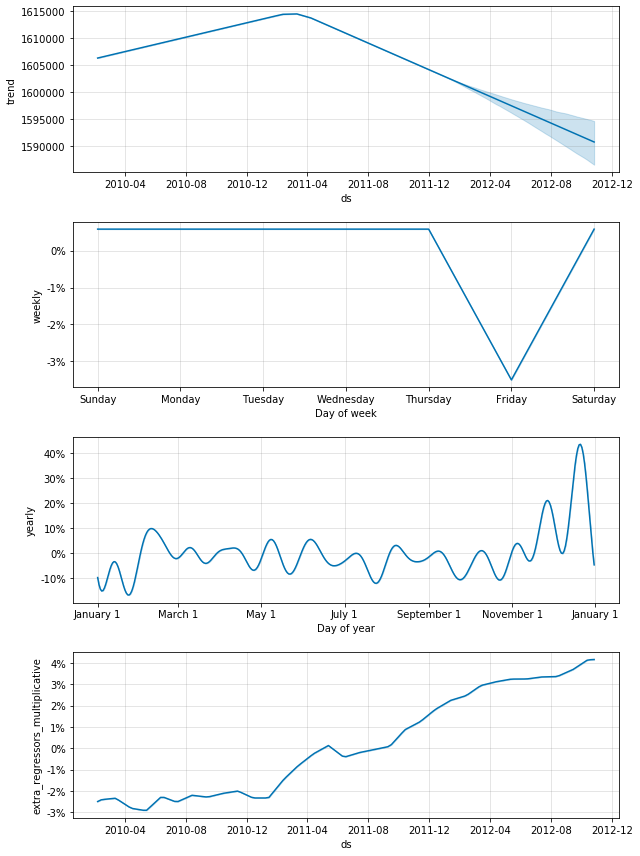

In [32]:
pd.plotting.register_matplotlib_converters()
f = m.plot_components(forecast)

<Figure size 1296x432 with 0 Axes>

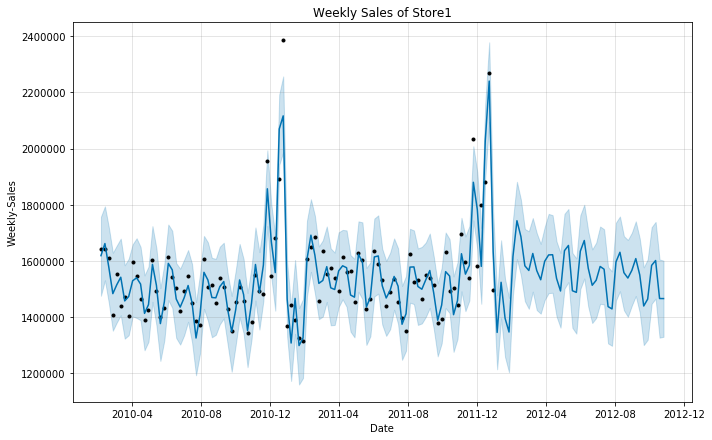

In [33]:
plt.figure(figsize=(18, 6))
m.plot(forecast, xlabel = 'Date', ylabel = 'Weekly-Sales')
plt.title('Weekly Sales of Store1');

In [34]:

verif = utility.make_verif(forecast, data_train, data_test)

In [35]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Store,Store_lower,Store_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,2010-02-05,1.606319e+06,1.476497e+06,1.757920e+06,1.606319e+06,1.606319e+06,-0.013299,-0.013299,-0.013299,-0.011673,-0.011673,-0.011673,-0.024972,-0.024972,-0.024972,0.007998,0.007998,0.007998,-0.035018,-0.035018,-0.035018,0.067988,0.067988,0.067988,0.0,0.0,0.0,1.619166e+06,1643690.90
2010-02-12,2010-02-12,1.606473e+06,1.531499e+06,1.794619e+06,1.606473e+06,1.606473e+06,-0.012513,-0.012513,-0.012513,-0.011673,-0.011673,-0.011673,-0.024186,-0.024186,-0.024186,0.034729,0.034729,0.034729,-0.035018,-0.035018,-0.035018,0.093933,0.093933,0.093933,0.0,0.0,0.0,1.662264e+06,1641957.44
2010-02-19,2010-02-19,1.606627e+06,1.450027e+06,1.719237e+06,1.606627e+06,1.606627e+06,-0.012260,-0.012260,-0.012260,-0.011673,-0.011673,-0.011673,-0.023933,-0.023933,-0.023933,-0.018730,-0.018730,-0.018730,-0.035018,-0.035018,-0.035018,0.040221,0.040221,0.040221,0.0,0.0,0.0,1.576536e+06,1611968.17
2010-02-26,2010-02-26,1.606781e+06,1.352014e+06,1.629474e+06,1.606781e+06,1.606781e+06,-0.012096,-0.012096,-0.012096,-0.011673,-0.011673,-0.011673,-0.023768,-0.023768,-0.023768,-0.076410,-0.076410,-0.076410,-0.035018,-0.035018,-0.035018,-0.017624,-0.017624,-0.017624,0.0,0.0,0.0,1.484007e+06,1409727.59
2010-03-05,2010-03-05,1.606936e+06,1.381459e+06,1.655052e+06,1.606936e+06,1.606936e+06,-0.011931,-0.011931,-0.011931,-0.011673,-0.011673,-0.011673,-0.023604,-0.023604,-0.023604,-0.056736,-0.056736,-0.056736,-0.035018,-0.035018,-0.035018,0.001886,0.001886,0.001886,0.0,0.0,0.0,1.515764e+06,1554806.68
2010-03-12,2010-03-12,1.607090e+06,1.407108e+06,1.679869e+06,1.607090e+06,1.607090e+06,-0.011767,-0.011767,-0.011767,-0.011673,-0.011673,-0.011673,-0.023439,-0.023439,-0.023439,-0.040233,-0.040233,-0.040233,-0.035018,-0.035018,-0.035018,0.018224,0.018224,0.018224,0.0,0.0,0.0,1.542432e+06,1439541.59
2010-03-19,2010-03-19,1.607244e+06,1.323701e+06,1.584882e+06,1.607244e+06,1.607244e+06,-0.012656,-0.012656,-0.012656,-0.011673,-0.011673,-0.011673,-0.024329,-0.024329,-0.024329,-0.092770,-0.092770,-0.092770,-0.035018,-0.035018,-0.035018,-0.033424,-0.033424,-0.033424,0.0,0.0,0.0,1.458140e+06,1472515.79
2010-03-26,2010-03-26,1.607398e+06,1.335973e+06,1.608317e+06,1.607398e+06,1.607398e+06,-0.013721,-0.013721,-0.013721,-0.011673,-0.011673,-0.011673,-0.025394,-0.025394,-0.025394,-0.083219,-0.083219,-0.083219,-0.035018,-0.035018,-0.035018,-0.022807,-0.022807,-0.022807,0.0,0.0,0.0,1.473632e+06,1404429.92
2010-04-02,2010-04-02,1.607553e+06,1.402813e+06,1.659491e+06,1.607553e+06,1.607553e+06,-0.014786,-0.014786,-0.014786,-0.011673,-0.011673,-0.011673,-0.026459,-0.026459,-0.026459,-0.048399,-0.048399,-0.048399,-0.035018,-0.035018,-0.035018,0.013077,0.013077,0.013077,0.0,0.0,0.0,1.529748e+06,1594968.28


C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\ipykernel_launcher.py:41: FutureWarning:

clip_lower(threshold) is deprecated, use clip(lower=threshold) instead

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\ipykernel_launcher.py:42: FutureWarning:

clip_lower(threshold) is deprecated, use clip(lower=threshold) instead



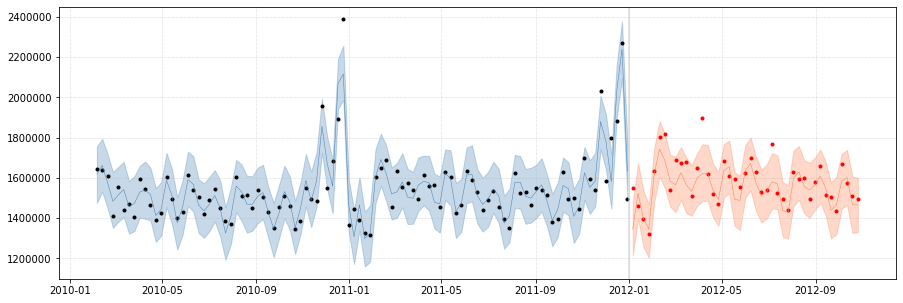

In [36]:
pd.plotting.register_matplotlib_converters()
def plot_verif1(verif, year=2012):
    """
    plots the forecasts and observed data, the `year` argument is used to visualise 
    the division between the training and test sets. 
    Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package
    year : integer
        The year used to separate the training and test set. Default 2017
    Returns
    -------
    f : matplotlib Figure object
    """
    
    f, ax = plt.subplots(figsize=(15,5))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)
f =  plot_verif1(verif,2012)

In [ ]:
!pip install statsmodels

     |████████████████████████████████| 8.7 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 33.0 MB/s eta 0:00:01
You should consider upgrading via the '/opt/venv/bin/python3 -m pip install --upgrade pip' command.


In [37]:
from statsmodels.tools.eval_measures import rmse
import datetime 
error=rmse(verif.loc[:'2012','y'].values,verif.loc[:'2012','yhat'].values)
error

72916.0944279131

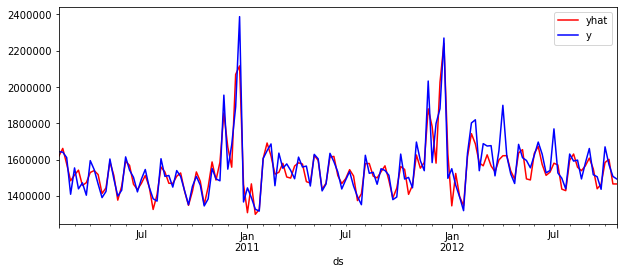

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Store,Store_lower,Store_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,2010-02-05,1.606319e+06,1.476497e+06,1.757920e+06,1.606319e+06,1.606319e+06,-0.013299,-0.013299,-0.013299,-0.011673,-0.011673,-0.011673,-0.024972,-0.024972,-0.024972,0.007998,0.007998,0.007998,-0.035018,-0.035018,-0.035018,0.067988,0.067988,0.067988,0.0,0.0,0.0,1.619166e+06,1643690.90
2010-02-12,2010-02-12,1.606473e+06,1.531499e+06,1.794619e+06,1.606473e+06,1.606473e+06,-0.012513,-0.012513,-0.012513,-0.011673,-0.011673,-0.011673,-0.024186,-0.024186,-0.024186,0.034729,0.034729,0.034729,-0.035018,-0.035018,-0.035018,0.093933,0.093933,0.093933,0.0,0.0,0.0,1.662264e+06,1641957.44
2010-02-19,2010-02-19,1.606627e+06,1.450027e+06,1.719237e+06,1.606627e+06,1.606627e+06,-0.012260,-0.012260,-0.012260,-0.011673,-0.011673,-0.011673,-0.023933,-0.023933,-0.023933,-0.018730,-0.018730,-0.018730,-0.035018,-0.035018,-0.035018,0.040221,0.040221,0.040221,0.0,0.0,0.0,1.576536e+06,1611968.17
2010-02-26,2010-02-26,1.606781e+06,1.352014e+06,1.629474e+06,1.606781e+06,1.606781e+06,-0.012096,-0.012096,-0.012096,-0.011673,-0.011673,-0.011673,-0.023768,-0.023768,-0.023768,-0.076410,-0.076410,-0.076410,-0.035018,-0.035018,-0.035018,-0.017624,-0.017624,-0.017624,0.0,0.0,0.0,1.484007e+06,1409727.59
2010-03-05,2010-03-05,1.606936e+06,1.381459e+06,1.655052e+06,1.606936e+06,1.606936e+06,-0.011931,-0.011931,-0.011931,-0.011673,-0.011673,-0.011673,-0.023604,-0.023604,-0.023604,-0.056736,-0.056736,-0.056736,-0.035018,-0.035018,-0.035018,0.001886,0.001886,0.001886,0.0,0.0,0.0,1.515764e+06,1554806.68
2010-03-12,2010-03-12,1.607090e+06,1.407108e+06,1.679869e+06,1.607090e+06,1.607090e+06,-0.011767,-0.011767,-0.011767,-0.011673,-0.011673,-0.011673,-0.023439,-0.023439,-0.023439,-0.040233,-0.040233,-0.040233,-0.035018,-0.035018,-0.035018,0.018224,0.018224,0.018224,0.0,0.0,0.0,1.542432e+06,1439541.59
2010-03-19,2010-03-19,1.607244e+06,1.323701e+06,1.584882e+06,1.607244e+06,1.607244e+06,-0.012656,-0.012656,-0.012656,-0.011673,-0.011673,-0.011673,-0.024329,-0.024329,-0.024329,-0.092770,-0.092770,-0.092770,-0.035018,-0.035018,-0.035018,-0.033424,-0.033424,-0.033424,0.0,0.0,0.0,1.458140e+06,1472515.79
2010-03-26,2010-03-26,1.607398e+06,1.335973e+06,1.608317e+06,1.607398e+06,1.607398e+06,-0.013721,-0.013721,-0.013721,-0.011673,-0.011673,-0.011673,-0.025394,-0.025394,-0.025394,-0.083219,-0.083219,-0.083219,-0.035018,-0.035018,-0.035018,-0.022807,-0.022807,-0.022807,0.0,0.0,0.0,1.473632e+06,1404429.92
2010-04-02,2010-04-02,1.607553e+06,1.402813e+06,1.659491e+06,1.607553e+06,1.607553e+06,-0.014786,-0.014786,-0.014786,-0.011673,-0.011673,-0.011673,-0.026459,-0.026459,-0.026459,-0.048399,-0.048399,-0.048399,-0.035018,-0.035018,-0.035018,0.013077,0.013077,0.013077,0.0,0.0,0.0,1.529748e+06,1594968.28


In [38]:
# verif['yhat'].plot(legend=True, color='red', figsize=(10,8))
# dataset_for_prediction1['Weekly_Sales'].plot(legend=True, color='green', figsize=(20,8))
# dataset_for_prediction1['Weekly_Sales'].plot(legend=True, color='green', figsize=(20,8))
# verif['y'].plot(legend=True, color='blue', figsize=(10,8))

fig=verif['yhat'].plot(legend=True, color='red', figsize=(10,4))
fig=verif['y'].plot(legend=True, color='blue')
# fig.set_figheight(4)
plt.show()
verif

# SARIMAX

In [40]:
Store1 = dataset_grouped[(dataset_grouped.Store==1)]
steps=-1
dataset_for_prediction1= Store1.copy()
dataset_for_prediction1['Actual_sales']=dataset_for_prediction1['Weekly_Sales'].shift(steps)
dataset_for_prediction1=dataset_for_prediction1.dropna()
dataset_for_prediction1['Date'] =pd.to_datetime(dataset_for_prediction1['Date'])
dataset_for_prediction1.index= dataset_for_prediction1['Date']
# dataset_for_prediction1.head()
X = dataset_for_prediction1[['Store','CPI','Weekly_Sales']]
y = dataset_for_prediction1[['Actual_sales']]
y.rename(columns={'Actual_sales':'Next_week_Sale'},inplace = True)
train_size=int(len(Store1) *0.7)
test_size = int(len(Store1)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

the 'freq' keyword is deprecated, use 'period' instead



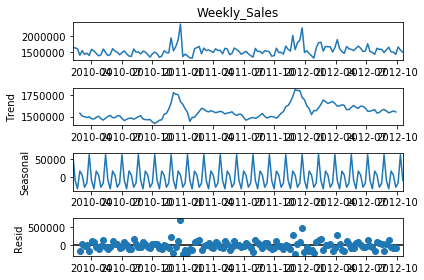

In [41]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Weekly_Sales'],model='add',freq=7);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [42]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [43]:
y_test=y['Next_week_Sale'][:train_size].dropna()
test_adf(y_test, " Weekly Sales")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary  Weekly Sales


In [45]:
!pip install pmdarima

In [46]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

RuntimeError: Failed to solve the system of normal equations


In [ ]:
step_wise.summary()

/opt/venv/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1340.405
Date:                Thu, 12 Mar 2020   AIC                           2690.810
Time:                        19:30:39   BIC                           2703.786
Sample:                    02-05-2010   HQIC                          2696.060
                         - 12-30-2011                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -3932.5321   2.21e+04     -0.178      0.859   -4.72e+04    3.93e+04
Store                 0        nan        nan        nan         nan         nan
CPI           2.818e+04   1.28e+05      0.220      0.826   -2.23e+05    2.79e+05
Weekly_Sales    -0.4101      0.055     -7.419      0.000      -0.518      -0.302
sigma2        3.371e+10      0.318   1.06e+11      0.000    3.37e+10    3.37e+10
===================================================================================
Ljung-Box (Q):                       48.74   Jarque-Bera (JB):               103.77
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               3.80   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.81e+23. Standard errors may be unstable.
"""

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(train_y, seasonal_order=(0,1,0,52),
 exog=train_X,
 order=(0,1,0),
 enforce_invertibility=False, enforce_stationarity=False)

results= model.fit()
results.summary()

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Next_week_Sale   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -646.619
Date:                            Tue, 12 May 2020   AIC                           1301.238
Time:                                    12:21:50   BIC                           1308.553
Sample:                                02-05-2010   HQIC                          1303.978
                                     - 12-30-2011                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Store                 0   9.86e-22          0      1.000   -1.93e-21    1.93e-21
CPI           1.224e+04   1.66e+06      0.007      0.994   -3.23e+06    3.26e+06
Weekly_Sales    -0.4910      5.048     -0.097      0.923     -10.385       9.403
sigma2        2.526e+11      0.026    9.8e+12      0.000    2.53e+11    2.53e+11
===================================================================================
Ljung-Box (Q):                       85.18   Jarque-Bera (JB):                 6.63
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               1.33   Skew:                            -0.43
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+35. Standard errors may be unstable.
"""

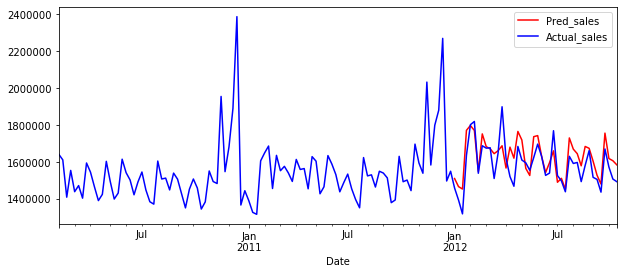

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Store,Store_lower,Store_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,2010-02-05,1.606319e+06,1.476497e+06,1.757920e+06,1.606319e+06,1.606319e+06,-0.013299,-0.013299,-0.013299,-0.011673,-0.011673,-0.011673,-0.024972,-0.024972,-0.024972,0.007998,0.007998,0.007998,-0.035018,-0.035018,-0.035018,0.067988,0.067988,0.067988,0.0,0.0,0.0,1.619166e+06,1643690.90
2010-02-12,2010-02-12,1.606473e+06,1.531499e+06,1.794619e+06,1.606473e+06,1.606473e+06,-0.012513,-0.012513,-0.012513,-0.011673,-0.011673,-0.011673,-0.024186,-0.024186,-0.024186,0.034729,0.034729,0.034729,-0.035018,-0.035018,-0.035018,0.093933,0.093933,0.093933,0.0,0.0,0.0,1.662264e+06,1641957.44
2010-02-19,2010-02-19,1.606627e+06,1.450027e+06,1.719237e+06,1.606627e+06,1.606627e+06,-0.012260,-0.012260,-0.012260,-0.011673,-0.011673,-0.011673,-0.023933,-0.023933,-0.023933,-0.018730,-0.018730,-0.018730,-0.035018,-0.035018,-0.035018,0.040221,0.040221,0.040221,0.0,0.0,0.0,1.576536e+06,1611968.17
2010-02-26,2010-02-26,1.606781e+06,1.352014e+06,1.629474e+06,1.606781e+06,1.606781e+06,-0.012096,-0.012096,-0.012096,-0.011673,-0.011673,-0.011673,-0.023768,-0.023768,-0.023768,-0.076410,-0.076410,-0.076410,-0.035018,-0.035018,-0.035018,-0.017624,-0.017624,-0.017624,0.0,0.0,0.0,1.484007e+06,1409727.59
2010-03-05,2010-03-05,1.606936e+06,1.381459e+06,1.655052e+06,1.606936e+06,1.606936e+06,-0.011931,-0.011931,-0.011931,-0.011673,-0.011673,-0.011673,-0.023604,-0.023604,-0.023604,-0.056736,-0.056736,-0.056736,-0.035018,-0.035018,-0.035018,0.001886,0.001886,0.001886,0.0,0.0,0.0,1.515764e+06,1554806.68
2010-03-12,2010-03-12,1.607090e+06,1.407108e+06,1.679869e+06,1.607090e+06,1.607090e+06,-0.011767,-0.011767,-0.011767,-0.011673,-0.011673,-0.011673,-0.023439,-0.023439,-0.023439,-0.040233,-0.040233,-0.040233,-0.035018,-0.035018,-0.035018,0.018224,0.018224,0.018224,0.0,0.0,0.0,1.542432e+06,1439541.59
2010-03-19,2010-03-19,1.607244e+06,1.323701e+06,1.584882e+06,1.607244e+06,1.607244e+06,-0.012656,-0.012656,-0.012656,-0.011673,-0.011673,-0.011673,-0.024329,-0.024329,-0.024329,-0.092770,-0.092770,-0.092770,-0.035018,-0.035018,-0.035018,-0.033424,-0.033424,-0.033424,0.0,0.0,0.0,1.458140e+06,1472515.79
2010-03-26,2010-03-26,1.607398e+06,1.335973e+06,1.608317e+06,1.607398e+06,1.607398e+06,-0.013721,-0.013721,-0.013721,-0.011673,-0.011673,-0.011673,-0.025394,-0.025394,-0.025394,-0.083219,-0.083219,-0.083219,-0.035018,-0.035018,-0.035018,-0.022807,-0.022807,-0.022807,0.0,0.0,0.0,1.473632e+06,1404429.92
2010-04-02,2010-04-02,1.607553e+06,1.402813e+06,1.659491e+06,1.607553e+06,1.607553e+06,-0.014786,-0.014786,-0.014786,-0.011673,-0.011673,-0.011673,-0.026459,-0.026459,-0.026459,-0.048399,-0.048399,-0.048399,-0.035018,-0.035018,-0.035018,0.013077,0.013077,0.013077,0.0,0.0,0.0,1.529748e+06,1594968.28


In [50]:
%matplotlib inline
# steps = -1
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)
act= pd.DataFrame(y.iloc[train_size:, :])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual_sales'] = act['Next_week_Sale']
predictions.rename(columns={0:'Pred_sales'}, inplace=True)
Final_predictions = pd.concat([predictions,act],axis=1)
# Final_predictions['Pred_sales'].plot(legend=True, color='red', figsize=(20,8))
# dataset_for_prediction2['Actual_sales'].plot(legend=True, color='blue', figsize=(20,8))
fig=Final_predictions['Pred_sales'].plot(legend=True, color='red', figsize=(10,4))
fig=dataset_for_prediction1['Actual_sales'].plot(legend=True, color='blue')
# fig.set_figheight(4)
plt.show()
verif



In [51]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred_sales'], predictions['Actual_sales'])
error

83318.6341630936

# Random Forest

In [197]:
## New markdown cell
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

In [198]:
Store1.head()
Store1 = Store1.groupby(['Date','Store','CPI'])['Weekly_Sales'].sum().reset_index()
Store1.head()

,Date,Store,Dept,CPI,Weekly_Sales
0,2010-02-05,1,1.0,211.096358,24924.50
1,2010-02-05,1,2.0,211.096358,50605.27
2,2010-02-05,1,3.0,211.096358,13740.12
3,2010-02-05,1,4.0,211.096358,39954.04
4,2010-02-05,1,5.0,211.096358,32229.38


,Date,Store,CPI,Weekly_Sales
0,2010-02-05,1,211.096358,1643690.90
1,2010-02-12,1,211.242170,1641957.44
2,2010-02-19,1,211.289143,1611968.17
3,2010-02-26,1,211.319643,1409727.59
4,2010-03-05,1,211.350143,1554806.68


In [199]:
Store1.Date = pd.to_datetime(Store1.Date)
Store1.dtypes

Date            datetime64[ns]
Store                    int64
CPI                    float64
Weekly_Sales           float64
dtype: object

In [200]:
Store1.head()

,Date,Store,CPI,Weekly_Sales
0,2010-02-05,1,211.096358,1643690.90
1,2010-02-12,1,211.242170,1641957.44
2,2010-02-19,1,211.289143,1611968.17
3,2010-02-26,1,211.319643,1409727.59
4,2010-03-05,1,211.350143,1554806.68


In [201]:
# Store1.drop('Date',axis = 1, inplace=True)
Store1.index = Store1['Date']
Store1.head()

,Date,Store,CPI,Weekly_Sales
Date,,,,
2010-02-05,2010-02-05,1,211.096358,1643690.90
2010-02-12,2010-02-12,1,211.242170,1641957.44
2010-02-19,2010-02-19,1,211.289143,1611968.17
2010-02-26,2010-02-26,1,211.319643,1409727.59
2010-03-05,2010-03-05,1,211.350143,1554806.68


In [202]:
# Store1['sale_year'], Store1['sale_month'], Store1['sale_day'] = Store1.Date.dt.year,Store1.Date.dt.month,Store1.Date.dt.day
import re
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

add_datepart(Store1, 'Date')

In [203]:
Store1.head()

,Store,CPI,Weekly_Sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,
2010-02-05,1,211.096358,1643690.90,2010,2,5,5,4,36,False,False,False,False,False,False,1265328000
2010-02-12,1,211.242170,1641957.44,2010,2,6,12,4,43,False,False,False,False,False,False,1265932800
2010-02-19,1,211.289143,1611968.17,2010,2,7,19,4,50,False,False,False,False,False,False,1266537600
2010-02-26,1,211.319643,1409727.59,2010,2,8,26,4,57,False,False,False,False,False,False,1267142400
2010-03-05,1,211.350143,1554806.68,2010,3,9,5,4,64,False,False,False,False,False,False,1267747200


In [152]:
# Store1.drop('Date',axis = 1, inplace=True)
# Store1.head()

,Store,CPI,Weekly_Sales,sale_year,sale_month,sale_day
Date,,,,,,
2010-02-05,1,211.096358,1643690.90,2010,2,5
2010-02-12,1,211.242170,1641957.44,2010,2,12
2010-02-19,1,211.289143,1611968.17,2010,2,19
2010-02-26,1,211.319643,1409727.59,2010,2,26
2010-03-05,1,211.350143,1554806.68,2010,3,5


In [204]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_trn = int(len(Store1) *0.7)
x = Store1.drop('Weekly_Sales',axis = 1)
y = Store1[['Weekly_Sales']]
X_train, X_test = split_vals(x, n_trn)
y_train, y_test = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_test.shape

((100, 15), (100, 1), (43, 15))

In [285]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt',0.5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,3,5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [20, 260, 500], 'max_features': ['auto', 'sqrt', 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 3, 5], 'bootstrap': [True, False]}


In [286]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished
C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [20, 260, 500], 'max_features': ['auto', 'sqrt', 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 3, 5], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [287]:
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': 100,
 'bootstrap': False}

In [289]:
from statsmodels.tools.eval_measures import rmse

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
    rmse_err = rmse(predictions, test_labels['Weekly_Sales'])
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    
    print('Model Performance')
    print(f'RMSE: {rmse_err}')
   
    return rmse

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print(random_accuracy)

85193.52138123791

Model Performance
RMSE: 77207.84730350364
<function rmse at 0x000001AF2353D2F0>


In [291]:
import math
from statsmodels.tools.eval_measures import rmse

np.random.seed(500)
# m = RandomForestRegressor(n_estimators=39, n_jobs=-1, min_samples_leaf=3,oob_score= True,max_features=0.5) #oob_score=True
m = RandomForestRegressor(n_estimators=20, n_jobs=-1, min_samples_split=5,min_samples_leaf= 1,max_features=0.5,max_depth=100,bootstrap=False) #oob_score=True
m.fit(X_train,y_train)
predictions = m.predict(X_test)
error=rmse(predictions, y_test['Weekly_Sales'])
error
# print_score(m)

C:\Users\FX253KA\AppData\Local\Continuum\anaconda3\envs\last\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

74786.57513396055

In [292]:
predictions_df = pd.DataFrame(predictions)
predictions_df.rename(columns = {0:'Pred'},inplace = True)
predictions_df.head(10)

,Pred
0,1.542393e+06
1,1.527214e+06
2,1.488252e+06
3,1.492549e+06
4,1.670842e+06
5,1.665061e+06
6,1.663465e+06
7,1.566309e+06
8,1.662850e+06
9,1.626327e+06


In [293]:
predictions_df.head()

,Pred
0,1.542393e+06
1,1.527214e+06
2,1.488252e+06
3,1.492549e+06
4,1.670842e+06


In [294]:
y_test['that'] = list(predictions_df['Pred'])
y_test

,Weekly_Sales,that
Date,,
2012-01-06,1550369.92,1.542393e+06
2012-01-13,1459601.17,1.527214e+06
2012-01-20,1394393.84,1.488252e+06
2012-01-27,1319325.59,1.492549e+06
2012-02-03,1636339.65,1.670842e+06
2012-02-10,1802477.43,1.665061e+06
2012-02-17,1819870.00,1.663465e+06
2012-02-24,1539387.83,1.566309e+06
2012-03-02,1688420.76,1.662850e+06


In [295]:
final_rf = pd.concat([y_test,X_test],axis = 1)

In [296]:
# final_rf['Weekly_Sales'] = np.exp(final_rf['Weekly_Sales_log'])
final_rf.head()

,Weekly_Sales,that,Store,CPI,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,,
2012-01-06,1550369.92,1.542393e+06,1,219.714258,2012,1,1,6,4,6,False,False,False,False,False,False,1325808000
2012-01-13,1459601.17,1.527214e+06,1,219.892526,2012,1,2,13,4,13,False,False,False,False,False,False,1326412800
2012-01-20,1394393.84,1.488252e+06,1,219.985689,2012,1,3,20,4,20,False,False,False,False,False,False,1327017600
2012-01-27,1319325.59,1.492549e+06,1,220.078852,2012,1,4,27,4,27,False,False,False,False,False,False,1327622400
2012-02-03,1636339.65,1.670842e+06,1,220.172015,2012,2,5,3,4,34,False,False,False,False,False,False,1328227200


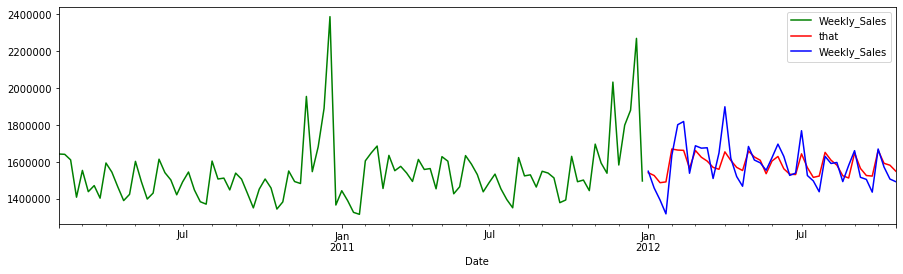

In [297]:
pd.plotting.register_matplotlib_converters()
fig=y_train['Weekly_Sales'].plot(legend=True, color='green', figsize=(15,4))
fig=final_rf['that'].plot(legend=True, color='red')
fig=final_rf['Weekly_Sales'].plot(legend=True, color='blue')


In [298]:
from statsmodels.tools.eval_measures import rmse
error=rmse(final_rf['that'], final_rf['Weekly_Sales'])
error

74786.57513396055

RMSE : Prophet : 72916.0944279131
RMSE : SARIMAX : 83318.6341630936
RMSE : Random Forest : 74786.57513396055